# 第7章: 単語ベクトル

単語の意味を実ベクトルで表現する単語ベクトル（単語埋め込み）に関して，以下の処理を行うプログラムを作成せよ.

## 60. 単語ベクトルの読み込みと表示

Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル（300万単語・フレーズ，300次元）をダウンロードし，”United States”の単語ベクトルを表示せよ．ただし，”United States”は内部的には”United_States”と表現されていることに注意せよ．

In [4]:
import pandas as pd
import numpy as np
import gensim

/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [6]:
model['United_States'][:20]

array([-0.03613281, -0.04833984,  0.23535156,  0.17480469, -0.14648438,
       -0.07421875, -0.1015625 , -0.07714844,  0.109375  , -0.05712891,
       -0.1484375 , -0.06005859,  0.17480469, -0.07714844,  0.02587891,
       -0.07666016, -0.03808594,  0.13574219,  0.03759766, -0.04199219],
      dtype=float32)

## 61. 単語の類似度

“United States”と”U.S.”のコサイン類似度を計算せよ．

In [4]:
def cosine_sim(vec1, vec2):
  return np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
cosine_sim(model['United_States'],model['U.S.'])

0.7310775

In [5]:
model.similarity('United_States','U.S.')

0.7310774

## 62. 類似度の高い単語10件

“United States”とコサイン類似度が高い10語と，その類似度を出力せよ．

In [6]:
model.most_similar('United_States')

[('Unites_States', 0.7877249717712402),
 ('Untied_States', 0.7541371583938599),
 ('United_Sates', 0.74007248878479),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178409457206726),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.6019068956375122)]

## 63. 加法構成性によるアナロジー

“Spain”の単語ベクトルから”Madrid”のベクトルを引き，”Athens”のベクトルを足したベクトルを計算し，そのベクトルと類似度の高い10語とその類似度を出力せよ

In [7]:
model.most_similar(positive=['Spain','Athens'], negative=['Madrid'])

[('Greece', 0.6898480653762817),
 ('Aristeidis_Grigoriadis', 0.5606847405433655),
 ('Ioannis_Drymonakos', 0.5552908778190613),
 ('Greeks', 0.5450685620307922),
 ('Ioannis_Christou', 0.5400863289833069),
 ('Hrysopiyi_Devetzi', 0.5248444676399231),
 ('Heraklio', 0.5207759737968445),
 ('Athens_Greece', 0.516880989074707),
 ('Lithuania', 0.5166866183280945),
 ('Iraklion', 0.5146791338920593)]

## 64. アナロジーデータでの実験

単語アナロジーの評価データをダウンロードし，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．

In [8]:
!wget http://download.tensorflow.org/data/questions-words.txt

--2021-05-11 13:39:21--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.220.144
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.220.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt.2’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.06s   

2021-05-11 13:39:21 (8.91 MB/s) - ‘questions-words.txt.2’ saved [603955/603955]



In [7]:
with open("questions-words.txt", 'r') as qw, open("output.txt",'w') as out:
#   splitlines = qw.read().splitlines()
  for line in qw:
    if len(line.split()) == 4:
      most_similar = model.most_similar(positive=[line.split()[1],line.split()[2]], negative=[line.split()[0]])[0]
      word = most_similar[0]
      degree = most_similar[1]
      writestr = "{} {} {}\n".format(line, word, degree)
      out.write(writestr)
    elif line.split()[0] == ':':
      out.write(line+"\n")

In [18]:
!head output.txt

: capital-common-countries
Athens Greece Baghdad Iraq Iraqi 0.6351870894432068
Athens Greece Bangkok Thailand Thailand 0.7137669920921326
Athens Greece Beijing China China 0.7235777378082275
Athens Greece Berlin Germany Germany 0.6734623908996582
Athens Greece Bern Switzerland Switzerland 0.4919748306274414
Athens Greece Cairo Egypt Egypt 0.7527807950973511
Athens Greece Canberra Australia Australia 0.583732545375824
Athens Greece Hanoi Vietnam Viet_Nam 0.6276342272758484
Athens Greece Havana Cuba Cuba 0.6460990905761719


## 65. アナロジータスクでの正解率

64の実行結果を用い，意味的アナロジー（semantic analogy）と文法的アナロジー（syntactic analogy）の正解率を測定せよ．

In [2]:
vec_semantic = []
real_semantic = []
vec_syntactic = []
real_syntactic = []
semsyn = ''
with open("output.txt",'r') as file:
  splitlines = file.read().splitlines()
  for line in splitlines:
    linesplit = line.split()
    if len(linesplit) == 6:
      if semsyn == 'syn':
        real_syntactic.append(linesplit[3])
        vec_syntactic.append(linesplit[4])
      else:
        real_semantic.append(linesplit[3])
        vec_semantic.append(linesplit[4])
    elif linesplit[0] == ':':
      if 'gram' in line:
        semsyn = 'syn'
      else:
        semsyn = 'sym'

In [42]:
from sklearn.metrics import accuracy_score
sem_accuracy = accuracy_score(vec_semantic, real_semantic)
syn_accuracy = accuracy_score(vec_syntactic, real_syntactic)
print("sematic: ", sem_accuracy)
print("syntactic: ", syn_accuracy)

sematic:  0.7308602999210734
syntactic:  0.7400468384074942


## 66. WordSimilarity-353での評価

The WordSimilarity-353 Test Collectionの評価データをダウンロードし，単語ベクトルにより計算される類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ

In [76]:
df = pd.read_csv("wordsim353/combined.csv")
compute_score = []
for i in range(len(df)):
  compute_score.append(model.similarity(df.iloc[i]['Word 1'],df.iloc[i]['Word 2']))
df['Computed'] = compute_score
# df['Computed'] *= 10

In [77]:
from scipy import stats
stats.spearmanr(df['Human (mean)'],df['Computed'])

SpearmanrResult(correlation=0.7000166486272194, pvalue=2.86866666051422e-53)

## 67. k-meansクラスタリング

国名に関する単語ベクトルを抽出し，k-meansクラスタリングをクラスタ数k=5として実行せよ．

In [96]:
# Getting countries name
flag = 0
countries = set()
with open("output.txt",'r') as file:
  splitlines = file.read().splitlines()
  for line in splitlines:
    linesplit = line.split()
    if len(linesplit) == 6:
      if flag == 1:
        countries.add(linesplit[1])
      elif flag == 2:
        countries.add(linesplit[0])
    elif linesplit[0] == ':':
      if line in [": capital-common-countries",": capital-world"]:
        flag = 1
      elif line == ': currency':
        flag = 2
      else:
        flag = 0
countries = list(countries)
country_vec = [model[x] for x in countries]

In [111]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=5, random_state=0).fit(country_vec)
df = pd.DataFrame({"Country":countries, "Cluster":kmeans.labels_})

for i in range(5):
  print(df[df["Cluster"] == i])

       Country  Cluster
1      Ecuador        0
3        Samoa        0
8       Guyana        0
9     Suriname        0
35   Nicaragua        0
37    Dominica        0
40     Uruguay        0
53       Chile        0
56      Belize        0
61     Bahamas        0
71     Jamaica        0
72   Venezuela        0
81        Cuba        0
87        Peru        0
94   Argentina        0
107   Honduras        0
110     Brazil        0
124     Mexico        0
        Country  Cluster
4         Gabon        1
6        Uganda        1
10      Algeria        1
12        Ghana        1
22      Burundi        1
24   Madagascar        1
26   Mauritania        1
38        Niger        1
39       Gambia        1
42         Mali        1
43      Tunisia        1
46      Liberia        1
47        Sudan        1
48       Malawi        1
49   Mozambique        1
51       Angola        1
59        Kenya        1
60      Senegal        1
65     Zimbabwe        1
90      Somalia        1
91       Rwanda    

## 68. Ward法によるクラスタリング

国名に関する単語ベクトルに対し，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

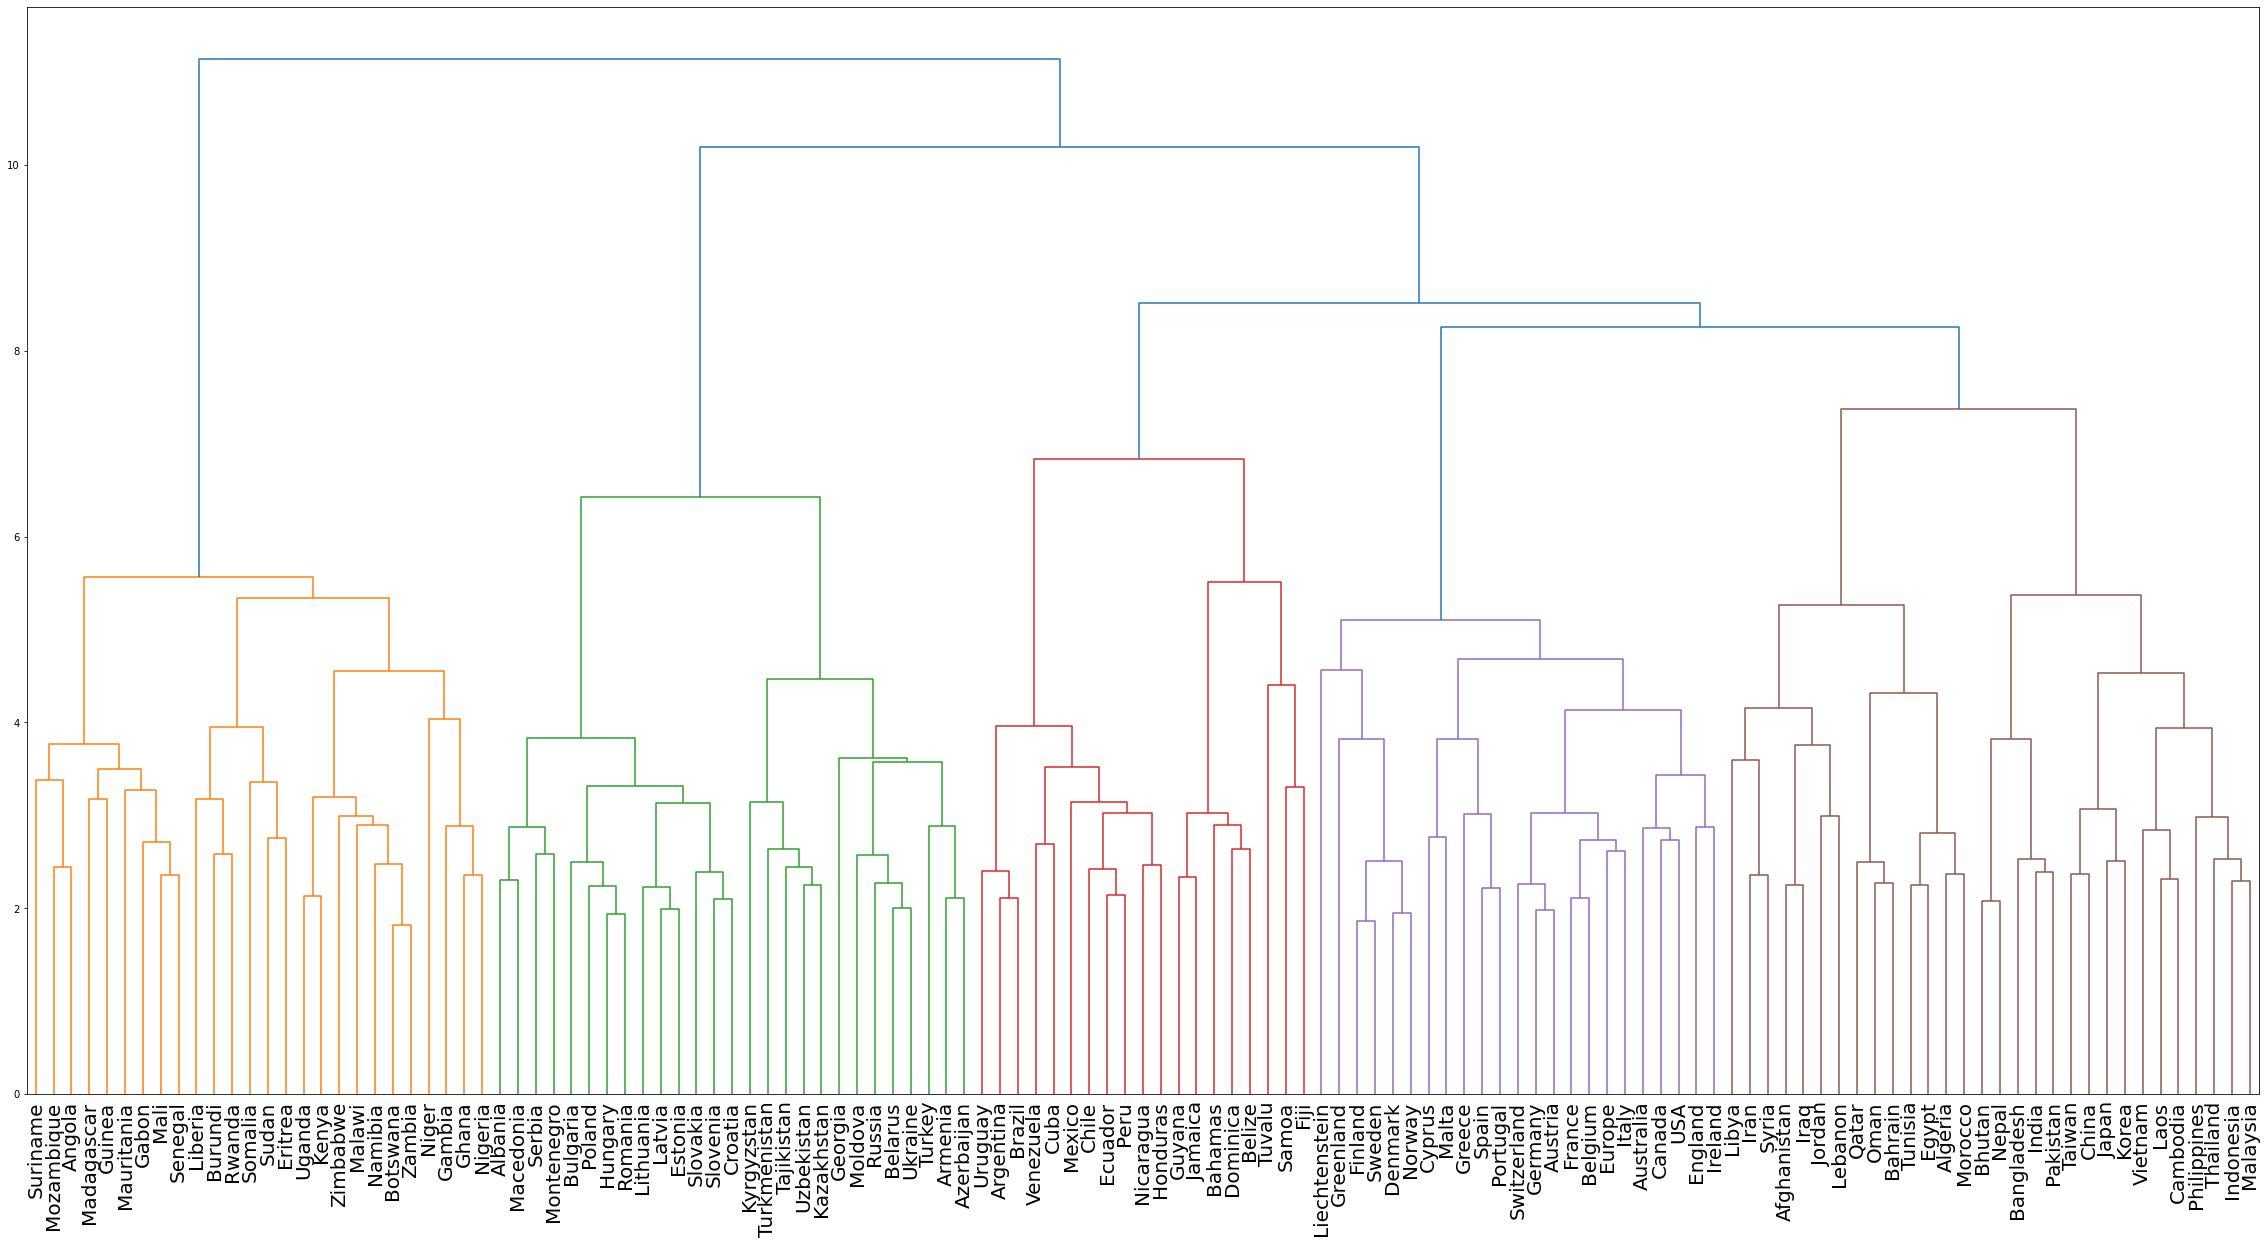

In [134]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(40,20))
dendogram = sch.dendrogram(sch.linkage(country_vec, method='ward'), labels=countries, leaf_font_size=20)
plt.show()

## 69. t-SNEによる可視化

ベクトル空間上の国名に関する単語ベクトルをt-SNEで可視化せよ．

In [166]:
from sklearn.manifold import TSNE
country_vec_embedded = TSNE().fit_transform(country_vec)
x = country_vec_embedded[:,0]
y = country_vec_embedded[:,1]

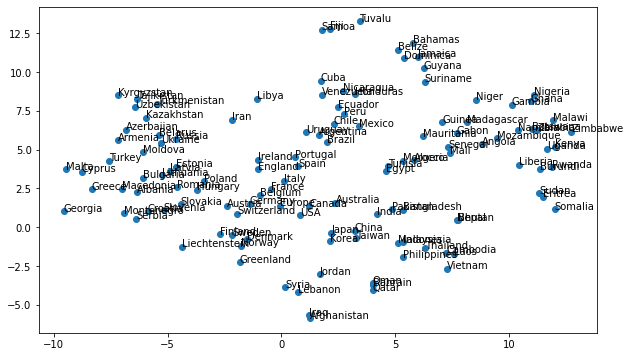

In [176]:
# import seaborn as sns
plt.figure(figsize=(10,6))
plt.scatter(x,y)
for coor, country in zip(country_vec_embedded, countries):
  plt.annotate(country, coor)
plt.show()